## 題目: 將Kaggle Dataset SMS文件以機器學習方式分辨是否為垃圾郵件<br>
說明：輸入文件spam.csv是一個至少有兩欄v1和v2的csv檔，v1註明該簡訊是ham還是spam，v2是sms內容本身，<br>
我們在讀入後先去掉不必要的欄位內容，將欄位名稱改為labels和data，再將labels內容改成0/1，0<br>
代表ham1代表spam。接著將內容切割成訓練集和測試集，再用tokenizer做前處理，最後形成可以分析的格式。<br>
建模分析之後我們印出訓練和測試準確度，然後以word cloud畫出spam和ham常用的字，
再分別印出判斷錯誤的SMS供未來改進。<br>
延伸:可用不同的tokenizer，不同的ML分類器做改進準確率的比較。<br>
範例程式檔名: spam_sms_垃圾簡訊偵測器.py，以Naïve Bayes (MultinomialNB) 方式完成<br>
模組: sklearn, pandas, numpy, wordcloud<br>
輸入檔：spam.csv<br>
成績：辨識百分率<br>
進一步說明：<br>
在這個習題中，我們從Kaggle下載SMS簡訊資料，經由前處理之後判斷是否為SPAM<br>
並畫出垃圾字雲來<br>

###以下是本習題要做的<br>

1.前處理：<br>
 刪除不必要的欄位<br>
 重新命名欄位<br>
 二元數位化標記(labels)<br>

2.特徵：可選用 Count or TF-IDF<br>
3.建模，訓練，印出<br>
4.列出判斷錯<br>

In [51]:
from __future__ import print_function, division
from future.utils import iteritems
from builtins import range


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from wordcloud import WordCloud

In [2]:
# 資料來自：
# https://www.kaggle.com/uciml/sms-spam-collection-dataset
df = pd.read_csv('/content/drive/MyDrive/NLP/spam.csv', encoding='ISO-8859-1')

In [3]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
# 刪除不必要的欄位
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

In [5]:
# 重新命名欄位
df.columns = ['label','data']

In [9]:
# 二元數位化標記(labels)
df['label_int'] = df['label'].map({'ham':0,'spam':1})
Y = df['label_int'].values

In [10]:
# 分為訓練與測試組
df_train, df_test, Ytrain, Ytest = train_test_split(df['data'], Y, test_size=0.33)

### 方法1:以TF-IDF 為特徵

In [90]:
tfidf = TfidfVectorizer(max_features=3300)
Xtrain_tfidf = tfidf.fit_transform(df_train)
Xtest_tfidf = tfidf.transform(df_test)
#for TfidfVectorizer, using 'max_features=3300' has a better performance

In [91]:
# 產生模型，訓練，印出 TFIDF
model_tfidf = MultinomialNB()
model_tfidf.fit(Xtrain_tfidf, Ytrain)
print("train score:", model_tfidf.score(Xtrain_tfidf, Ytrain))
print("test score:", model_tfidf.score(Xtest_tfidf, Ytest))

train score: 0.981516206804179
test score: 0.9728113104948342


In [92]:
# 找出判斷錯誤的地方
X = tfidf.transform(df['data'])
df['predictions_tfidf'] = model_tfidf.predict(X)

In [93]:
print(classification_report(df['label_int'], df['predictions_tfidf']))
print(confusion_matrix(df['label_int'], df['predictions_tfidf']))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4825
           1       1.00      0.84      0.91       747

    accuracy                           0.98      5572
   macro avg       0.99      0.92      0.95      5572
weighted avg       0.98      0.98      0.98      5572

[[4825    0]
 [ 119  628]]


In [ ]:
# 沒預測出的SPAM True 1 predict 0 (TN)
sneaky_spam = df[(df['predictions_tfidf'] == 0) & (df['label_int'] == 1)]['data']
for idx, msg in enumerate(sneaky_spam):
  print(idx,msg)

In [48]:
# 以為是SPAM其實誤判 True 0 predict 1
not_actually_spam = df[(df['predictions_tfidf'] == 1) & (df['label_int'] == 0)]['data']
for idx, msg in enumerate(not_actually_spam):
  print(idx,msg)

### 方法2:以數量為特徵

In [84]:
count_vectorizer = CountVectorizer()
Xtrain_count = count_vectorizer.fit_transform(df_train)
Xtest_count = count_vectorizer.transform(df_test)

In [74]:
sum = Xtrain_count.toarray().sum(axis=0)
index_list = [500,1000,2000,3000,3300,3500,4000,4500,4800,5000,5500,6000]
sum.sort()
for index in index_list:
    print(f'{index}th word shows up {sum[::-1][index]} times.')
#choose max_features=3300
#for CountVectorizer, without using 'max_features=3300' has a better performance

500th word shows up 16 times.
1000th word shows up 7 times.
2000th word shows up 3 times.
3000th word shows up 2 times.
3300th word shows up 1 times.
3500th word shows up 1 times.
4000th word shows up 1 times.
4500th word shows up 1 times.
4800th word shows up 1 times.
5000th word shows up 1 times.
5500th word shows up 1 times.
6000th word shows up 1 times.


In [85]:
# 產生模型，訓練，印出 Count
model_count = MultinomialNB()
model_count.fit(Xtrain_count, Ytrain)
print("train score:", model_count.score(Xtrain_count, Ytrain))
print("test score:", model_count.score(Xtest_count, Ytest))

train score: 0.994106616662202
test score: 0.9836867862969005


In [54]:
# 找出判斷錯誤的地方
X = count_vectorizer.transform(df['data'])
df['predictions_count'] = model_count.predict(X)

In [55]:
print(classification_report(df['label_int'], df['predictions_count']))
print(confusion_matrix(df['label_int'], df['predictions_count']))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      4825
           1       1.00      0.81      0.90       747

    accuracy                           0.97      5572
   macro avg       0.99      0.91      0.94      5572
weighted avg       0.98      0.97      0.97      5572

[[4824    1]
 [ 139  608]]


In [ ]:
# 沒預測出的SPAM True 1 predict 0 (TN)
sneaky_spam = df[(df['predictions_count'] == 0) & (df['label_int'] == 1)]['data']
for idx, msg in enumerate(sneaky_spam):
  print(idx,msg)

In [ ]:
# 以為是SPAM其實誤判 True 0 predict 1
not_actually_spam = df[(df['predictions_count'] == 1) & (df['label_int'] == 0)]['data']
for idx, msg in enumerate(not_actually_spam):
  print(idx,msg)

### 以wordcloud visualize 數據

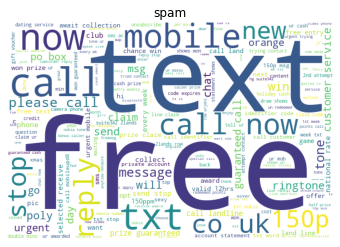

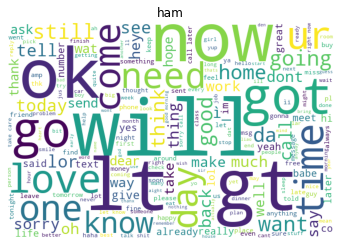

In [23]:
def visualize(label):
  words = ''
  for msg in df[df['label'] == label]['data']:
    msg = msg.lower()
    words += msg + ' '
  wordcloud = WordCloud(width=600, height=400, background_color='white').generate(words)
  plt.title(label)
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()

visualize('spam')
visualize('ham')